# Apartment Image Identification

Detects Street and Apartment numbers in the dataset03/ApartmentTraining images.  This identity is necessary for training as well as summarizing results (and also serves as a validation for the digits model)

In [276]:
import os
import os.path as osp
import json
from cvutils.mrcnn.session import init_keras_session
from celldom.dataset import utils as dataset_utils
from celldom.preprocessing import apartment_extraction
from skimage import io as sk_io
from skimage.exposure import rescale_intensity
from skimage.color import gray2rgb
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

init_keras_session()
plt.gray()

chip_config_path = osp.join(os.environ['CELLDOM_REPO_DIR'], 'config', 'chip_01_config.json')
model_path = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.2', 'digit_model', 'tune', 'single_digit_model.h5')
data_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'ApartmentTraining')
result_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'ApartmentTraining', 'analysis')

<Figure size 432x288 with 0 Axes>

In [70]:
with open(chip_config_path, 'r') as fd:
    chip_config = json.load(fd)

In [72]:
digit_model = keras.models.load_model(model_path)

In [73]:
data_files = dataset_utils.get_data_files(data_dir, patterns=['*.jpeg'])
data_files.head()

,image_name,image_path,annot_path,annot_exists
2023,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True
1741,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True
1332,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True
2082,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True
748,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True


In [74]:
data_files.annot_exists.value_counts()

False    5412
True      680
Name: annot_exists, dtype: int64

In [260]:
img = sk_io.imread(data_files['image_path'].iloc[630])
img.shape, img.dtype

((310, 235), dtype('uint8'))

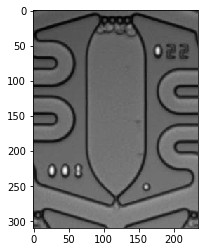

In [261]:
plt.imshow(img)

In [262]:
marker_y = -chip_config['apt_margins']['top']
marker_x = -chip_config['apt_margins']['left']
center = pd.DataFrame({'y': [marker_y], 'x': [marker_x]})
center

,x,y
0,160,250


In [263]:
with open(chip_config_path, 'r') as fd:
    chip_config = json.load(fd)
import imp
imp.reload(apartment_extraction)

<module 'celldom.preprocessing.apartment_extraction' from '/lab/repos/celldom/python/source/celldom/preprocessing/apartment_extraction.py'>

In [264]:
extractions = apartment_extraction.extract_images(img, center, chip_config)

In [265]:
len(extractions)

1

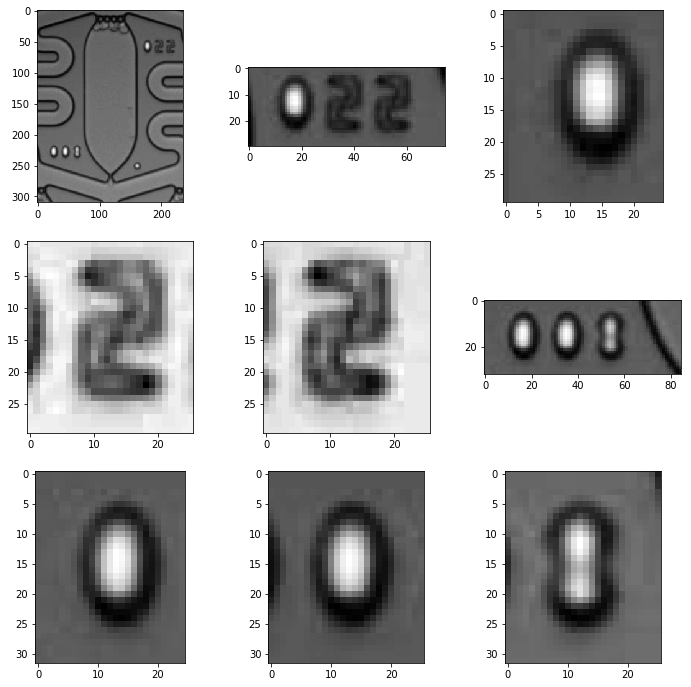

In [266]:
apartment_extraction.visualize_extraction(extractions[0])

In [267]:
def prep_digit_image(img):
    # Note that gray2rgb will take care of converting from uint8 to float in 0-1
    assert img.dtype == np.uint8
    img = gray2rgb(resize(img, (32, 32), mode='constant', anti_aliasing=True)).astype(np.float32)
    assert np.all(img <= 1.) and np.all(img >= 0.)
    return img

def get_digits(digit_imgs, digit_model):
    preds = digit_model.predict(np.stack([prep_digit_image(img) for img in digit_imgs]))
    digits = np.argmax(preds, axis=1)
    scores = np.max(preds, axis=1)
    return ''.join([str(d) for d in digits]), scores

def get_address(extraction, digit_model):
    apt_num, st_num = None, None
    
    if extraction.get('apartment_num_digit_images') is not None:
        apt_num, apt_num_scores = get_digits(extraction['apartment_num_digit_images'], digit_model)    
    if extraction.get('street_num_digit_images') is not None:
        st_num, st_num_scores = get_digits(extraction['street_num_digit_images'], digit_model)
    
    return apt_num, apt_num_scores, st_num, st_num_scores

In [268]:
get_address(extractions[0], digit_model)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


('022',
 array([0.99999964, 1.        , 1.        ], dtype=float32),
 '008',
 array([1.        , 1.        , 0.99999905], dtype=float32))

In [269]:
def run_identification(data_files):
    df = []
    for i, r in data_files.copy().iterrows():
        img = sk_io.imread(r['image_path'])
        extraction = apartment_extraction.extract_images(img, center, chip_config)[0]
        apt_num, apt_num_scores, st_num, st_num_scores = get_address(extraction, digit_model)
        r['apt_num'] = apt_num
        r['st_num'] = st_num
        df.append(r)
    return pd.DataFrame(df)

df_id = run_identification(data_files)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [270]:
df_id.head()

,image_name,image_path,annot_path,annot_exists,apt_num,st_num
2023,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,022,009
1741,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,022,009
1332,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,022,009
2082,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,022,009
748,BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...,/lab/data/celldom/dataset/dataset03/ApartmentT...,/lab/data/celldom/dataset/dataset03/ApartmentT...,True,022,009


In [271]:
df_id['approx_address'] = df_id['image_name'].apply(lambda v: v.split('-')[0])
df_id['cohort'] = df_id['image_name'].apply(lambda v: v.split('-')[1])
df_id['date'] = df_id['image_name'].apply(lambda v: v.split('-')[4])
df_id['z'] = df_id['image_name'].apply(lambda v: v.split('-')[5])
df_id.iloc[0]

image_name        BF_ST_006_APT_020-1nMQuiz-02-03-201805311723-z...
image_path        /lab/data/celldom/dataset/dataset03/ApartmentT...
annot_path        /lab/data/celldom/dataset/dataset03/ApartmentT...
annot_exists                                                   True
apt_num                                                         022
st_num                                                          009
approx_address                                    BF_ST_006_APT_020
cohort                                                      1nMQuiz
date                                                   201805311723
z                                                               z_0
Name: 2023, dtype: object

In [274]:
df_id[['st_num', 'apt_num']].isnull().describe()

,st_num,apt_num
count,6092,6092
unique,1,1
top,False,False
freq,6092,6092


In [275]:
df_id[['st_num', 'apt_num']].applymap(len).describe()

,st_num,apt_num
count,6092.0,6092.0
mean,3.0,3.0
std,0.0,0.0
min,3.0,3.0
25%,3.0,3.0
50%,3.0,3.0
75%,3.0,3.0
max,3.0,3.0


In [277]:
exp_path = osp.join(result_dir, 'identities.csv')
df_id.to_csv(exp_path, index=False)
exp_path

'/lab/data/celldom/dataset/dataset03/ApartmentTraining/associations/identities.csv'